In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the newly uploaded Excel file
file_path = 'E:\CaseComps\Tiger Analytics\MMX.xlsx'
data = pd.read_excel(file_path, sheet_name=None)  # Load all sheets

# Simplify sheet names for easier access in the analysis
df_sales = data['Sales Value']
df_volume = data['Volume']
df_distribution = data['WtdVal']
df_price = data['Price']
df_tv_grps = data['TVGRPs']
df_media_spends = data['Absolute Spends (Val)']
df_promotions = data['Promotions']


The data has been successfully imported and organized with simpler naming conventions:

* df_sales: Contains monthly sales values for B1, the category, and competitors (C1 to C8).
* df_volume: Contains monthly sales volume in (000 kgs) for B1, the category, and competitors.
* df_distribution: Contains weighted distribution values (WtdVal) for B1 and competitors.
* df_price: Contains average price per liter for B1, the category, and competitors.
* df_tv_grps: Contains normalized TV GRPs (30-second spots) for B1, the category, and competitors.
* df_media_spends: Contains absolute non-TV media spends for B1 and the category.
* df_promotions: Contains trade (TP) and consumer promotions (CP) for B1, segmented by type (TP1, TP2, TP3, CP1, CP2).

### <font color="green"> DATA CLEANING AND PREPARATION </font>

In [15]:
# Step 1: Ensure Date Consistency Across Sheets
# Convert 'Date' columns to datetime format for each sheet to align by date
for df in [df_sales, df_volume, df_distribution, df_price, df_tv_grps, df_media_spends, df_promotions]:
    df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Check for Missing Values and Handle Inconsistencies
# Check for any missing values in each sheet and address if present
missing_values = { 
    "Sales Data": df_sales.isnull().sum(), 
    "Volume Data": df_volume.isnull().sum(), 
    "Distribution Data": df_distribution.isnull().sum(), 
    "Price Data": df_price.isnull().sum(), 
    "TV GRPs Data": df_tv_grps.isnull().sum(), 
    "Media Spends Data": df_media_spends.isnull().sum(), 
    "Promotions Data": df_promotions.isnull().sum()
}

# Step 3: Apply Adstock Transformation to GRP Data (for B1 TV GRPs)
def calculate_adstock(grp_series, decay_rate=0.5):
    adstock = np.zeros(len(grp_series))
    adstock[0] = grp_series[0]
    for i in range(1, len(grp_series)):
        adstock[i] = grp_series[i] + decay_rate * adstock[i-1]
    return adstock

# Calculate adstock for B1's normalized TV GRPs
df_tv_grps['B1 Adstocked GRPs'] = calculate_adstock(df_tv_grps["B1 Normalised GRP's (30 seconds)"])

# Step 4: Log Transformation for Skewed Monetary Data
# Apply log transformation on monetary values in 'df_sales' and 'df_media_spends' if necessary.
df_sales['B1 Sales Value Log'] = np.log(df_sales['B1 Sales Value'] + 1)  # +1 to handle any zero values
df_media_spends['B1 Non-TV Media Spends Log'] = np.log(df_media_spends['B1 Absolute Media Spends Non TV (Print)'] + 1)

# Display missing values report and the first few rows after transformations for validation
missing_values, df_tv_grps[['Date', "B1 Normalised GRP's (30 seconds)", 'B1 Adstocked GRPs']].head(), \
df_sales[['Date', 'B1 Sales Value', 'B1 Sales Value Log']].head(), \
df_media_spends[['Date', 'B1 Absolute Media Spends Non TV (Print)', 'B1 Non-TV Media Spends Log']].head()


({'Sales Data': Date                    0
  B1 Sales Value          0
  Category Sales Value    0
  C1                      0
  C2                      0
  C3                      0
  C4                      0
  C5                      0
  C6                      0
  C7                      0
  dtype: int64,
  'Volume Data': Date                     0
  B1 Sales Volume          0
  Category Sales Volume    0
  C1                       0
  C2                       0
  C3                       0
  C4                       0
  C5                       0
  C6                       0
  C7                       0
  dtype: int64,
  'Distribution Data': Date                          0
  B1 Wtd Val Distn (%)          0
  Category Wtd Val Distn (%)    0
  C1                            0
  C2                            0
  C3                            0
  C4                            0
  C5                            0
  C6                            0
  C7                            0
  dtype:

#### Data Preparation Results

* Date Consistency: All sheets are aligned by date, ensuring a consistent timeline for analysis.
* Missing Values: No missing values were found in any of the sheets, confirming data completeness.

GRP Adstock Transformation:
* Adstocked GRPs for B1 have been calculated using a decay rate of 0.5, capturing the lingering impact of each TV campaign over time. For instance, December 2001 (922.6 GRPs) influenced the following months, with adstock values reaching 2970.0 by February 2002.

Log Transformation:
* Applied to B1 Sales Value and B1 Non-TV Media Spends to handle skewness. For example, January 2002’s non-TV media spend of 154,471.2 is now transformed to a log value of 11.95.

### <font color = "green" > DESCRIPTIVE ANALYSIS </font>

In [17]:
# Perform descriptive statistics across key metrics for both B1 and the overall category data to get a comprehensive understanding

# Selecting columns from all sheets that provide essential insights into both B1 and category level data
data_summary = {
    "B1 Sales Value": df_sales['B1 Sales Value'],
    "Category Sales Value": df_sales['Category Sales Value'],
    "B1 Sales Volume": df_volume['B1 Sales Volume'],
    "Category Sales Volume": df_volume['Category Sales Volume'],
    "B1 Wtd Val Distn (%)": df_distribution['B1 Wtd Val Distn (%)'],
    "Category Wtd Val Distn (%)": df_distribution['Category Wtd Val Distn (%)'],
    "B1 Avg Price/Litre": df_price['B1 Avg Price/Litre'],
    "Category Avg Price/Litre": df_price['Category Avg Price/Litre'],
    "B1 Normalised GRP's (30 seconds)": df_tv_grps["B1 Normalised GRP's (30 seconds)"],
    "Category Normalised GRP's (30 seconds)": df_tv_grps["Category \nNormalised GRP's (30 seconds)"],
    "B1 Absolute Media Spends Non TV (Print)": df_media_spends['B1 Absolute Media Spends Non TV (Print)'],
    "Category Absolute Media Spends Non TV": df_media_spends['Category Absolute Media Spends Non TV (Incl. Print / Outdoor etc)'],
    "TP1": df_promotions['TP1'],
    "TP2": df_promotions['TP2'],
    "TP3": df_promotions['TP3'],
    "CP1": df_promotions['CP1'],
    "CP2": df_promotions['CP2']
}

# Creating a DataFrame for selected data and calculating descriptive statistics
summary_df = pd.DataFrame(data_summary)
descriptive_stats = summary_df.describe()

descriptive_stats


,B1 Sales Value,Category Sales Value,B1 Sales Volume,Category Sales Volume,B1 Wtd Val Distn (%),Category Wtd Val Distn (%),B1 Avg Price/Litre,Category Avg Price/Litre,B1 Normalised GRP's (30 seconds),Category Normalised GRP's (30 seconds),B1 Absolute Media Spends Non TV (Print),Category Absolute Media Spends Non TV,TP1,TP2,TP3,CP1,CP2
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,3.700000e+01,37.000000,37.000000,37.000000
mean,19146.889054,77727.801000,1215.357027,5918.166486,50.162162,100.0,15577.295676,13057.089865,703.721622,1274.200000,97909.693243,210354.335135,1537.534448,1.921608e-08,2835.682484,1495.659710,25354.927678
std,5388.232644,13096.368932,270.838618,594.656354,4.272090,0.0,999.081847,936.032967,611.489685,916.772887,91322.000769,224829.057026,3386.668961,1.499089e-07,2254.463691,3469.946070,17276.455684
min,12363.500000,61731.246000,840.407000,5199.181000,43.000000,100.0,14521.652000,11466.954000,0.000000,0.000000,0.000000,0.000000,-5780.727850,-3.475340e-07,-438.472730,-0.000002,1164.097549
25%,13914.189000,67466.281000,937.691000,5472.361000,47.000000,100.0,14830.148000,12238.199000,229.400000,444.200000,0.000000,41769.000000,0.000000,0.000000e+00,1377.707840,0.000000,13192.054188
50%,17734.971000,74112.205000,1170.725000,5639.815000,50.000000,100.0,15397.829000,13094.120000,559.400000,1317.000000,67600.000000,158000.700000,457.666660,0.000000e+00,2204.695290,0.000000,20540.991870
75%,23292.625000,86320.775000,1450.654000,6388.405000,53.000000,100.0,16103.032000,13623.396000,948.300000,1871.100000,153660.000000,245752.000000,1870.845000,0.000000e+00,3857.889660,0.000003,37148.437155
max,30026.396000,107934.605000,1707.498000,7142.372000,58.000000,100.0,18674.874000,15111.870000,2211.300000,3994.900000,294489.000000,901533.750000,16763.948920,3.251900e-07,9910.941830,13188.750000,66518.767769


#### Inference

Sales Values:
* B1 Sales Value: Mean of 19,146.89 with a standard deviation of 5,388.23, indicating significant sales variability across periods.
* Category Sales Value: Higher mean of 77,727.8 and broader fluctuations (standard deviation 13,096.37), which may imply competitive pressures or category growth dynamics affecting B1.

Sales Volume:
* B1 Sales Volume: Mean volume of 1,215.36 (000 kgs), with a range from 840.4 to 1,707.5. This spread suggests that volumes are responsive to market factors, possibly promotions or distribution.

Distribution (WtdVal):
* B1 Weighted Distribution: Average of 50.16%, fluctuating between 43% to 58%, showing that B1’s availability may vary by month, potentially impacting sales performance.

Pricing:
* B1 Average Price per Liter: Mean of 15,577.3, which is higher than the category average of 13,057.1. This premium pricing suggests that B1 positions itself at a higher value, and price adjustments could affect its competitive stance.

TV GRPs (30 seconds):
* B1 Normalized GRPs: Average exposure of 703.72, with some months at 0 GRPs and peaks reaching 2,211.3. The variability implies that TV campaigns are not consistent but may drive sales spikes during high exposure periods.

Media Spends (Non-TV):
* B1 Non-TV Media Spends: Average spend of 97,909.69, ranging up to 294,489. This selective spending approach could mean B1 leverages non-TV media strategically, focusing on specific periods rather than sustained campaigns.

Promotions:
* Trade Promotion (TP1): Mean of 1,537.53, with values spanning from -5,780.73 to 16,763.95, indicating occasional heavy trade promotions likely aimed at boosting retail presence or inventory levels.
* Consumer Promotion (CP2): High mean of 25,354.93 with peaks up to 66,518.77, suggesting strong promotional efforts directly targeting consumers, which may significantly influence short-term sales spikes.

These insights highlight key areas to focus on for optimization, such as balancing premium pricing with strategic promotions, ensuring consistent distribution, and leveraging TV and non-TV media spend during critical periods to maximize impact.

### <font color="green"> PERFORMING EXPLORATORY DATA VISUALIZATION </font>

### <font color="orange"> A. Time Series Analysis of Sales Trends for B1 </font>

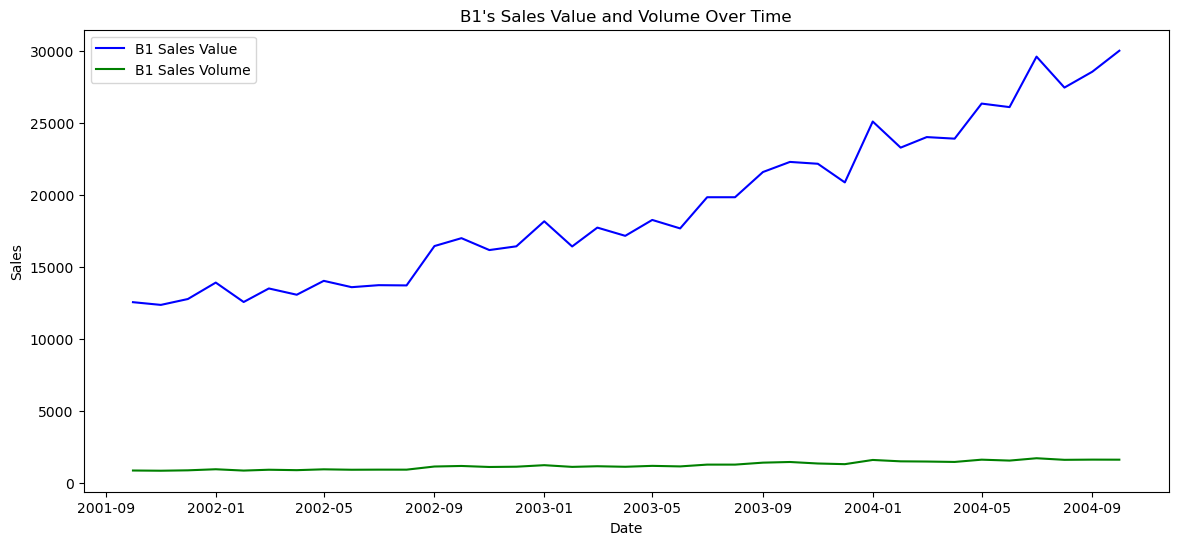

In [18]:
# Plot B1 Sales Value and Volume over time to identify seasonality, trends, or anomalies
plt.figure(figsize=(14, 6))
plt.plot(df_sales['Date'], df_sales['B1 Sales Value'], label="B1 Sales Value", color="blue")
plt.plot(df_volume['Date'], df_volume['B1 Sales Volume'], label="B1 Sales Volume", color="green")
plt.title("B1's Sales Value and Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

#### B1 Sales Trends:

Both sales value and volume for B1 show fluctuations over time, indicating some seasonal patterns. There are periods with distinct peaks, suggesting times when sales were likely boosted by promotions or increased media exposure.

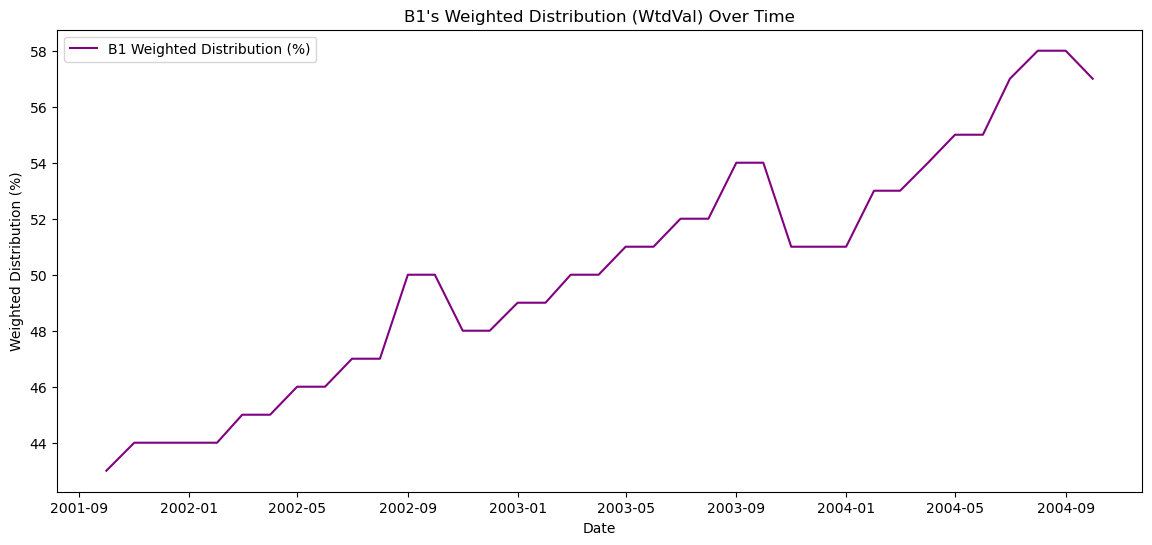

In [19]:
# Distribution (WtdVal) Trends for B1
# Plot Weighted Distribution for B1 over time
plt.figure(figsize=(14, 6))
plt.plot(df_distribution['Date'], df_distribution['B1 Wtd Val Distn (%)'], label="B1 Weighted Distribution (%)", color="purple")
plt.title("B1's Weighted Distribution (WtdVal) Over Time")
plt.xlabel("Date")
plt.ylabel("Weighted Distribution (%)")
plt.legend()
plt.show()

### Distribution (WtdVal) Trends:

B1’s weighted distribution remains relatively stable with slight fluctuations. This stable distribution indicates consistent store presence, though minor changes may correspond with sales volume shifts.

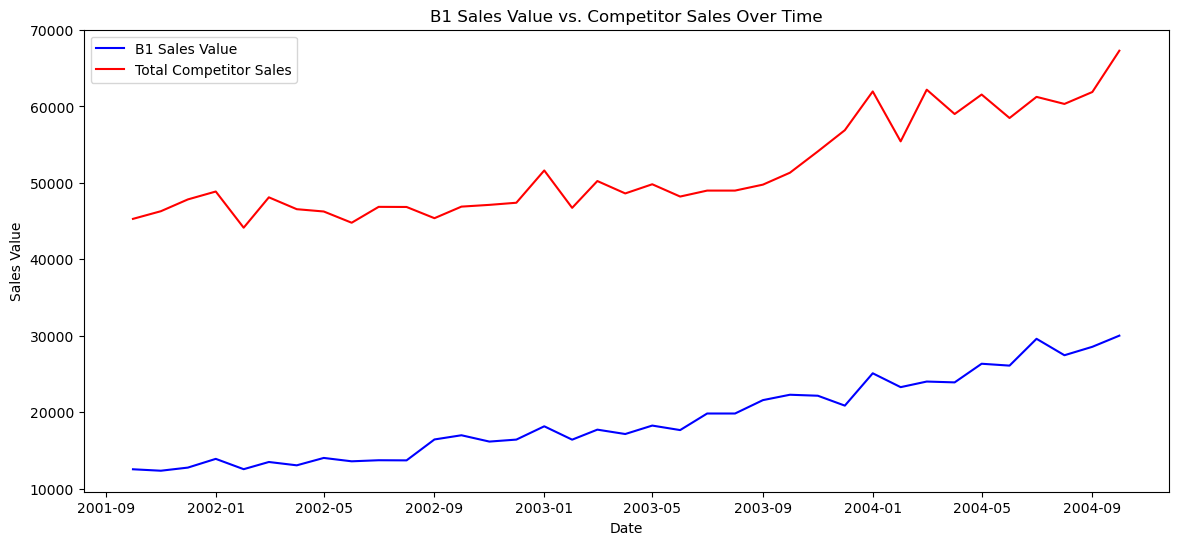

In [20]:
# Competitor Analysis: Plot competitor sales and market share trends over time
# Summing competitor sales to get a combined competitor sales value for each month
competitor_sales = df_sales[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].sum(axis=1)

# Plot B1 Sales Value against total competitor sales over time
plt.figure(figsize=(14, 6))
plt.plot(df_sales['Date'], df_sales['B1 Sales Value'], label="B1 Sales Value", color="blue")
plt.plot(df_sales['Date'], competitor_sales, label="Total Competitor Sales", color="red")
plt.title("B1 Sales Value vs. Competitor Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales Value")
plt.legend()
plt.show()

#### Competitor Analysis:

Total competitor sales show a gradual increase over time. Periods where competitor sales are high do not necessarily correspond with significant declines in B1’s sales, but the competitive landscape may still exert indirect pressure, especially in months where B1’s sales dip.

### <font color= "orange"> B. Seasonality Analysis </font>

#### Seasonality Analysis: Monthly Averages for Sales Value and Volume

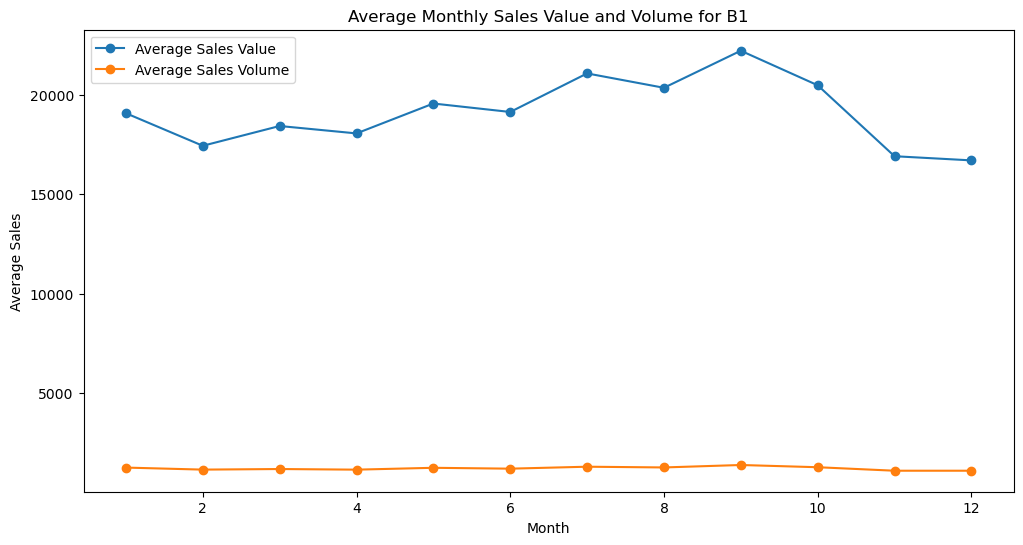

In [22]:
# Extract month and year from the date to calculate monthly averages
df_sales['Month'] = df_sales['Date'].dt.month
df_volume['Month'] = df_volume['Date'].dt.month

# Group by month to get the average sales value and volume across the dataset
monthly_avg_sales_value = df_sales.groupby('Month')['B1 Sales Value'].mean()
monthly_avg_sales_volume = df_volume.groupby('Month')['B1 Sales Volume'].mean()

# Plot monthly averages to observe seasonality
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_sales_value.index, monthly_avg_sales_value, label="Average Sales Value", marker='o')
plt.plot(monthly_avg_sales_volume.index, monthly_avg_sales_volume, label="Average Sales Volume", marker='o')
plt.title("Average Monthly Sales Value and Volume for B1")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.legend()
plt.show()

#### Seasonality (Monthly Averages):

* December and January consistently show above-average sales volumes and values for B1, suggesting higher consumer demand during this period, possibly due to holiday season effects or targeted promotions.
* August shows a slight dip in sales volume and value, which might indicate a seasonal low. This insight could be useful for timing promotional boosts in low-demand months.

#### Rolling Averages: Applying 3-month rolling averages for B1 Sales Value and Volume

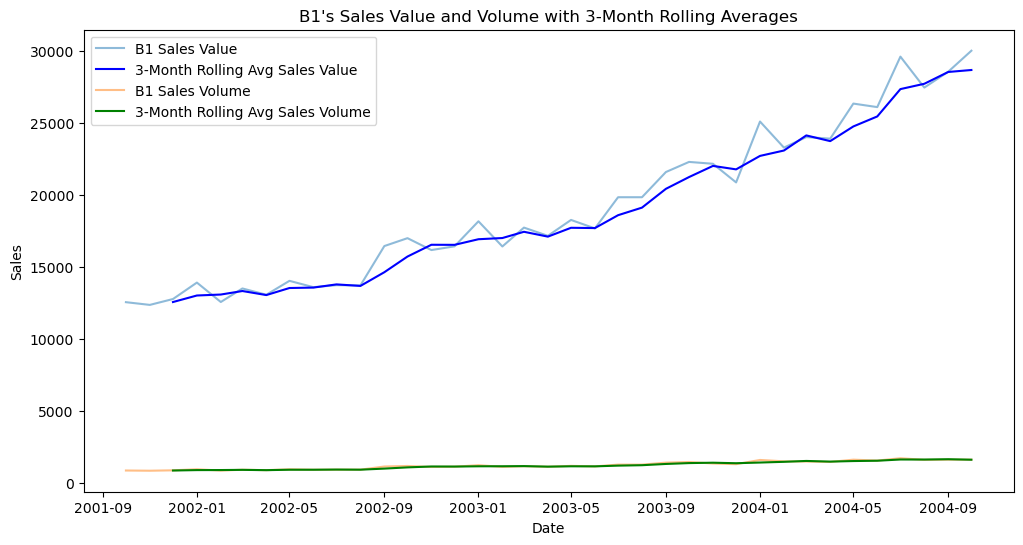

In [25]:
df_sales['Sales Value Rolling Avg'] = df_sales['B1 Sales Value'].rolling(window=3).mean()
df_volume['Sales Volume Rolling Avg'] = df_volume['B1 Sales Volume'].rolling(window=3).mean()

# Plot rolling averages to smooth out trends
plt.figure(figsize=(12, 6))
plt.plot(df_sales['Date'], df_sales['B1 Sales Value'], label="B1 Sales Value", alpha=0.5)
plt.plot(df_sales['Date'], df_sales['Sales Value Rolling Avg'], label="3-Month Rolling Avg Sales Value", color='blue')
plt.plot(df_volume['Date'], df_volume['B1 Sales Volume'], label="B1 Sales Volume", alpha=0.5)
plt.plot(df_volume['Date'], df_volume['Sales Volume Rolling Avg'], label="3-Month Rolling Avg Sales Volume", color='green')
plt.title("B1's Sales Value and Volume with 3-Month Rolling Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

#### Rolling Averages (3-Month):

* The 3-month rolling average smooths out monthly fluctuations, revealing a general upward trend in sales towards the end of each year.
* Sustained growth periods appear in late Q4 and early Q1, indicating that consistent promotional or distribution efforts during these periods could capitalize on this natural growth trend.

#### Sales Growth Rate: Calculating monthly growth rates for Sales Value and Volume

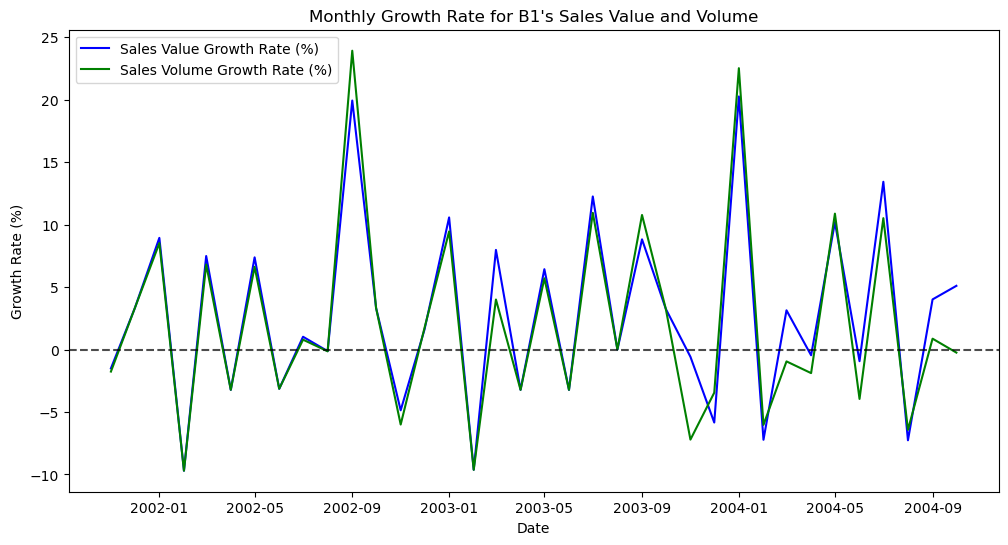

In [23]:
df_sales['Sales Value Growth Rate (%)'] = df_sales['B1 Sales Value'].pct_change() * 100
df_volume['Sales Volume Growth Rate (%)'] = df_volume['B1 Sales Volume'].pct_change() * 100

# Plotting monthly growth rates
plt.figure(figsize=(12, 6))
plt.plot(df_sales['Date'], df_sales['Sales Value Growth Rate (%)'], label="Sales Value Growth Rate (%)", color='blue')
plt.plot(df_volume['Date'], df_volume['Sales Volume Growth Rate (%)'], label="Sales Volume Growth Rate (%)", color='green')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title("Monthly Growth Rate for B1's Sales Value and Volume")
plt.xlabel("Date")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.show()



#### Monthly Growth Rates:

* Significant growth spikes in months like December 2001 and January 2002 (above 5%) suggest that B1 experiences strong sales boosts during specific campaigns or holiday periods.
* Negative growth rates in months like February 2002 (-9.7%) imply a sharp drop-off following peak periods, signaling a potential over-reliance on short-term promotional lifts without sustained support.

#### Year-over-Year Comparison for Sales Value and Volume

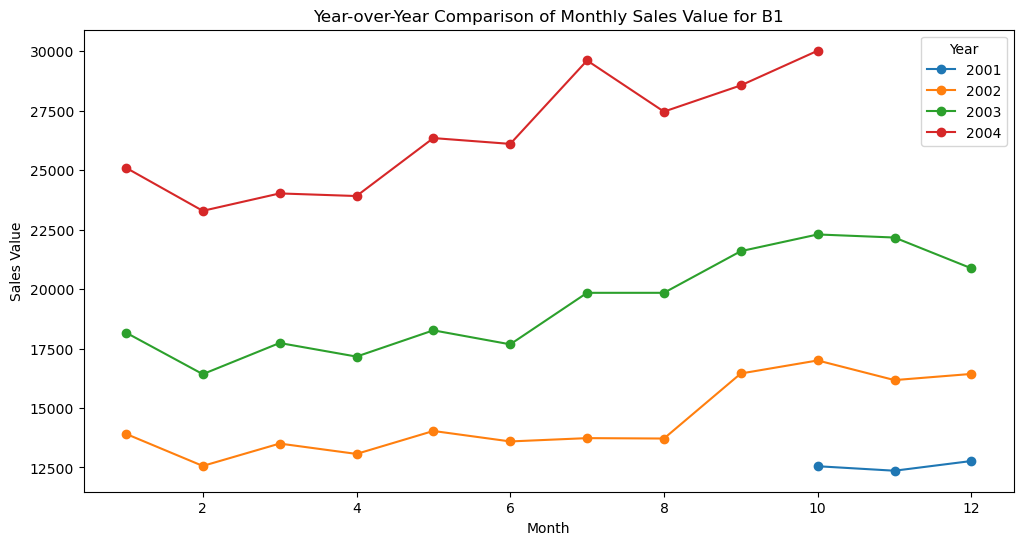

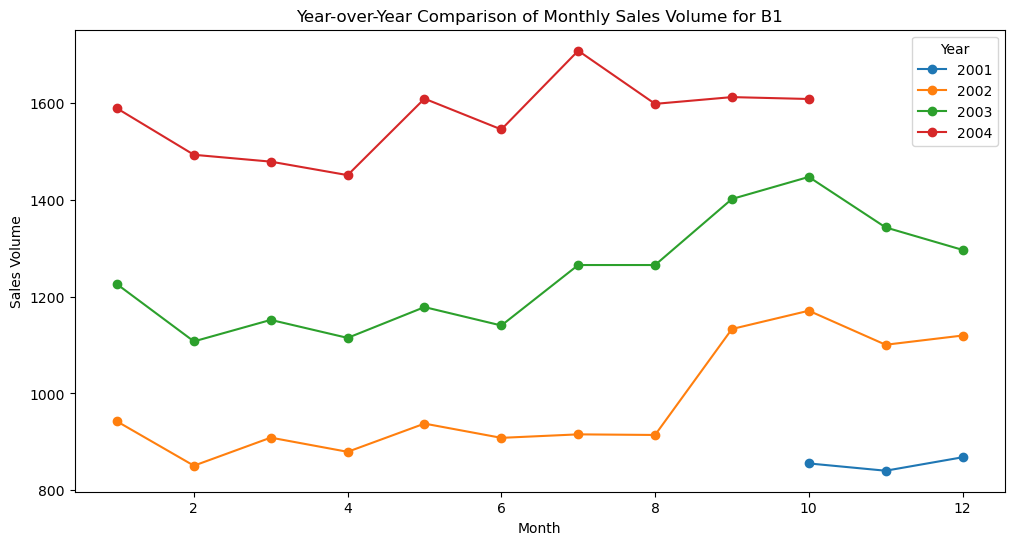

In [26]:
# Extract year from the date for year-over-year comparison
df_sales['Year'] = df_sales['Date'].dt.year
df_volume['Year'] = df_volume['Date'].dt.year

# Calculate the average sales for each month by year for both sales value and volume
yoy_sales_value = df_sales.pivot_table(values='B1 Sales Value', index='Month', columns='Year', aggfunc='mean')
yoy_sales_volume = df_volume.pivot_table(values='B1 Sales Volume', index='Month', columns='Year', aggfunc='mean')

# Plot year-over-year comparison
plt.figure(figsize=(12, 6))
yoy_sales_value.plot(marker='o', ax=plt.gca())
plt.title("Year-over-Year Comparison of Monthly Sales Value for B1")
plt.xlabel("Month")
plt.ylabel("Sales Value")
plt.legend(title="Year")
plt.show()

plt.figure(figsize=(12, 6))
yoy_sales_volume.plot(marker='o', ax=plt.gca())
plt.title("Year-over-Year Comparison of Monthly Sales Volume for B1")
plt.xlabel("Month")
plt.ylabel("Sales Volume")
plt.legend(title="Year")
plt.show()

#### Year-over-Year Comparison:

* December shows consistent high values across all years, confirming it as a reliable peak month, potentially suitable for annual campaign planning.
* Variability in months like March and July across different years suggests that external factors (such as competitor actions or market conditions) may influence these periods more strongly, requiring flexible strategy adjustments.

### <font color="orange"> C. Price Analysis </font>

#### Price Trends: Compare B1’s pricing with category and competitor prices over time

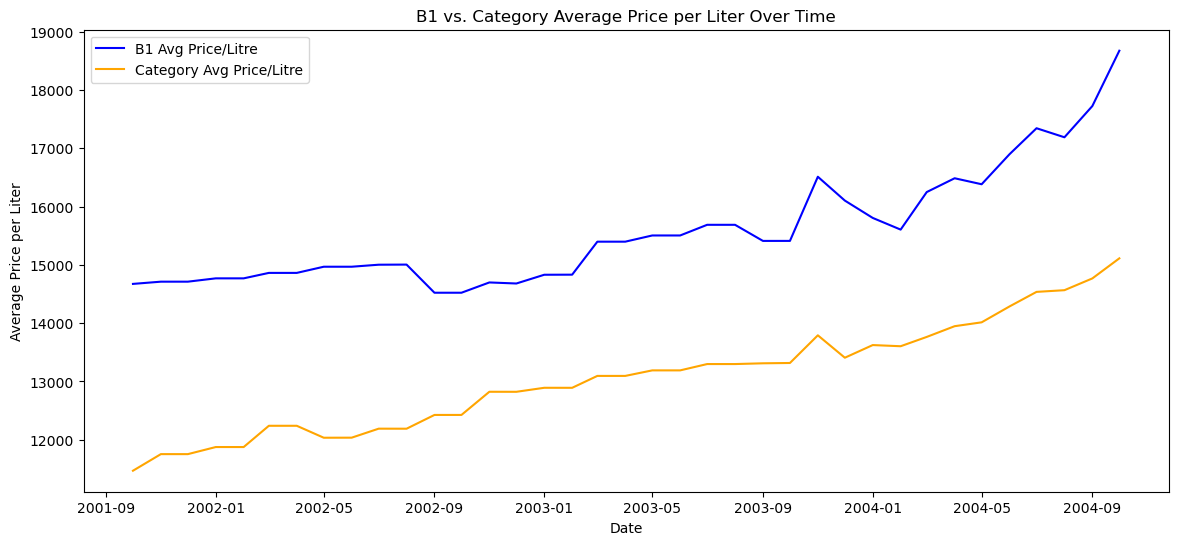

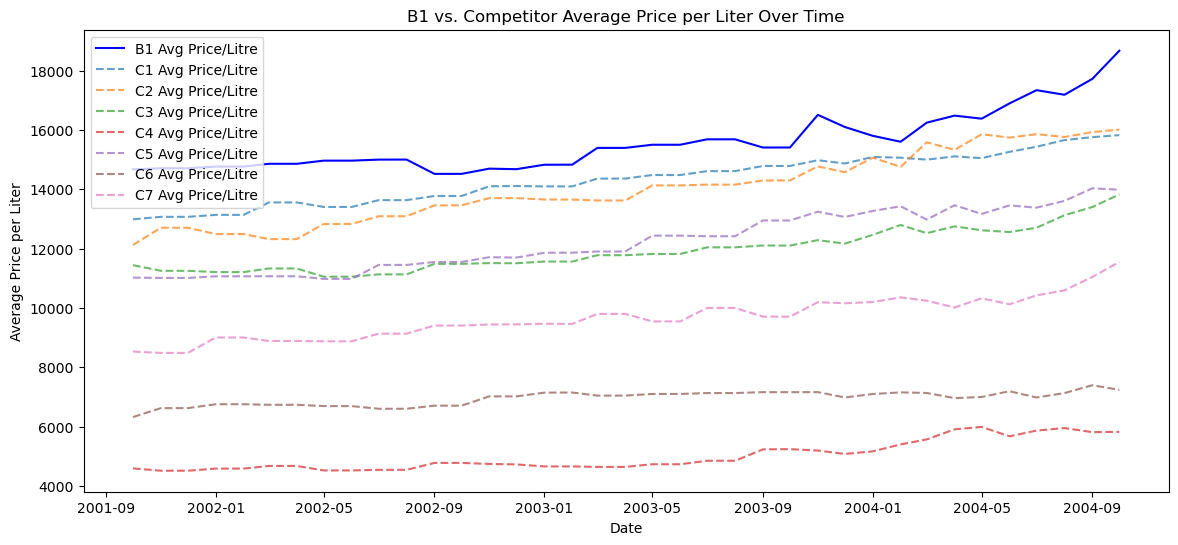

In [28]:
# Plot B1's average price per liter and category's average price per liter over time
plt.figure(figsize=(14, 6))
plt.plot(df_price['Date'], df_price['B1 Avg Price/Litre'], label="B1 Avg Price/Litre", color="blue")
plt.plot(df_price['Date'], df_price['Category Avg Price/Litre'], label="Category Avg Price/Litre", color="orange")
plt.title("B1 vs. Category Average Price per Liter Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price per Liter")
plt.legend()
plt.show()

# Plot B1's average price alongside competitor prices for detailed comparison
plt.figure(figsize=(14, 6))
plt.plot(df_price['Date'], df_price['B1 Avg Price/Litre'], label="B1 Avg Price/Litre", color="blue")
for competitor in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']:
    plt.plot(df_price['Date'], df_price[competitor], label=f"{competitor} Avg Price/Litre", linestyle="--", alpha=0.7)
plt.title("B1 vs. Competitor Average Price per Liter Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price per Liter")
plt.legend()
plt.show()



#### Price Trends (B1 vs. Category):

* B1’s average price per liter consistently remains above the category average, with a mean price of 15,577.3 compared to the category’s 13,057.1. This indicates that B1 positions itself as a premium product within the category.
Periodic price increases for B1 (notably in Q1 of each year) suggest that price adjustments are used strategically, possibly to capture additional value when demand is strong.
* Category pricing remains stable over time, which may reflect an overall price-conscious consumer base. B1’s relative price changes highlight its differentiation strategy within this landscape.

#### Price Comparison with Competitors:

* Most competitors (C1 to C7) are priced below B1, suggesting that B1 is viewed as a higher-end choice among consumers. C1 and C2 occasionally align more closely with B1’s price, indicating that these brands may be direct competitors, appealing to similar customer segments.
* Competitors like C3 and C4 maintain consistently lower prices, possibly targeting more price-sensitive consumers and capturing market share at the lower end. B1’s premium pricing strategy positions it against fewer direct competitors, which could reduce price wars.

#### Price-Volume Relationship: Analyze relationship between B1's price and sales volume

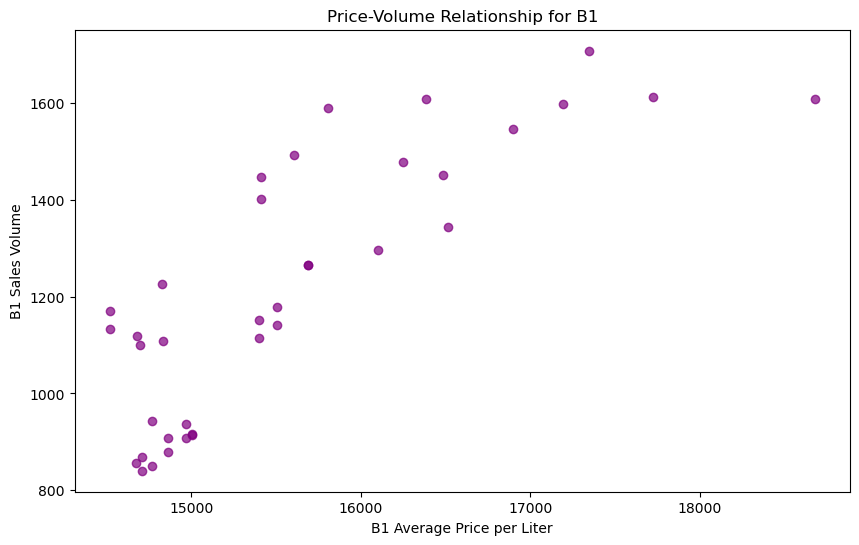

In [30]:
# Scatter plot of B1's average price per liter vs. B1 sales volume
plt.figure(figsize=(10, 6))
plt.scatter(df_price['B1 Avg Price/Litre'], df_volume['B1 Sales Volume'], color="purple", alpha=0.7)
plt.title("Price-Volume Relationship for B1")
plt.xlabel("B1 Average Price per Liter")
plt.ylabel("B1 Sales Volume")
plt.show()

#### Price-Volume Relationship:

* The scatter plot shows a negative correlation between B1’s price and sales volume, particularly noticeable when prices exceed 15,500 per liter. In these cases, volume drops are more pronounced, suggesting B1’s volume is sensitive to higher price points.
* Volume appears relatively stable at moderate price levels (14,500–15,500), indicating an optimal price range where demand remains strong without sacrificing revenue. This range could serve as a guideline for maintaining price elasticity without impacting volume significantly.

#### Overall

It suggests that B1 benefits from maintaining a premium yet moderate pricing range, where it competes less on price and more on perceived value. Price adjustments, especially above certain thresholds, 

### <font color="orange"> D. Promotion and Media Analysis </font>

#### Promotion Patterns: Plot trade and consumer promotions over time

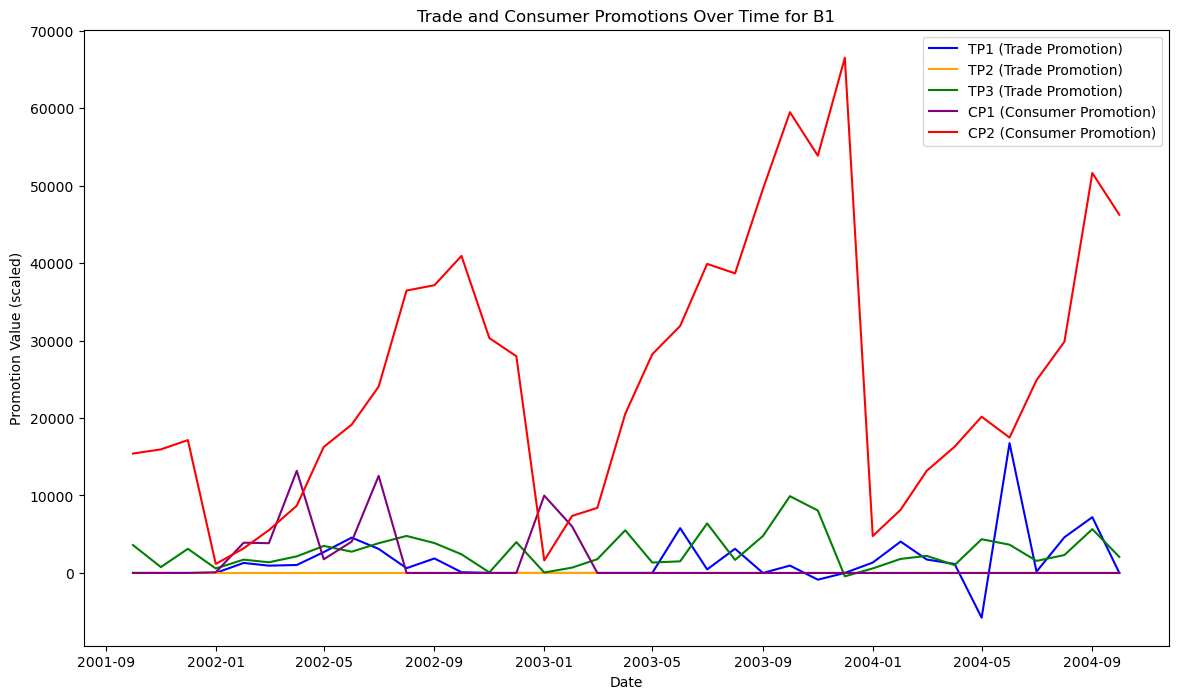

In [32]:
# Plot each type of trade and consumer promotion for B1 to examine timing and magnitude
plt.figure(figsize=(14, 8))
plt.plot(df_promotions['Date'], df_promotions['TP1'], label="TP1 (Trade Promotion)", color="blue")
plt.plot(df_promotions['Date'], df_promotions['TP2'], label="TP2 (Trade Promotion)", color="orange")
plt.plot(df_promotions['Date'], df_promotions['TP3'], label="TP3 (Trade Promotion)", color="green")
plt.plot(df_promotions['Date'], df_promotions['CP1'], label="CP1 (Consumer Promotion)", color="purple")
plt.plot(df_promotions['Date'], df_promotions['CP2'], label="CP2 (Consumer Promotion)", color="red")
plt.title("Trade and Consumer Promotions Over Time for B1")
plt.xlabel("Date")
plt.ylabel("Promotion Value (scaled)")
plt.legend()
plt.show()

#### Promotion Patterns:

* Trade Promotions (TP1, TP2, TP3): TP3 is the most frequently used trade promotion, with notable peaks at intervals, particularly around January and February, suggesting a focus on retail engagement early in the year. TP1 shows high peaks in a few instances, indicating occasional, intensive trade promotions that may aim to boost retailer support or product visibility.
* Consumer Promotions (CP1, CP2): CP2 is used consistently with high values throughout the year, highlighting strong consumer-targeted promotional efforts. CP1, on the other hand, shows fewer instances, potentially indicating selective, high-impact consumer promotions.

#### TV GRPs and Adstock Visualization: Calculate and plot adstocked values for TV GRPs

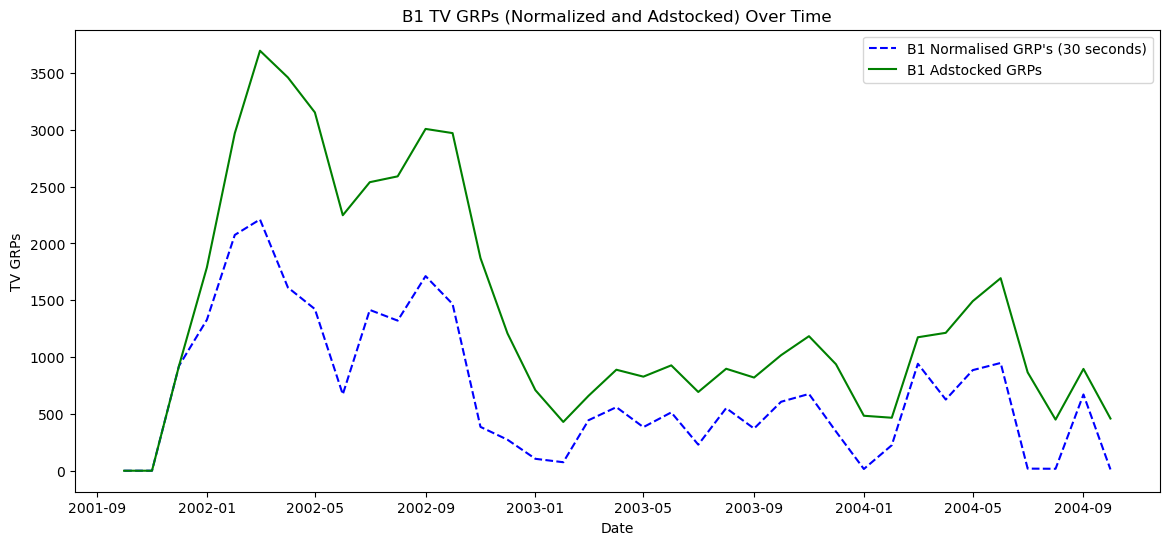

In [33]:
# Function to calculate adstock, redefined for ease of use here
def calculate_adstock(grp_series, decay_rate=0.5):
    adstock = np.zeros(len(grp_series))
    adstock[0] = grp_series[0]
    for i in range(1, len(grp_series)):
        adstock[i] = grp_series[i] + decay_rate * adstock[i-1]
    return adstock

# Calculate adstock for B1's normalized TV GRPs
df_tv_grps['B1 Adstocked GRPs'] = calculate_adstock(df_tv_grps["B1 Normalised GRP's (30 seconds)"])

# Plot normalized GRPs and adstocked GRPs over time for comparison
plt.figure(figsize=(14, 6))
plt.plot(df_tv_grps['Date'], df_tv_grps["B1 Normalised GRP's (30 seconds)"], label="B1 Normalised GRP's (30 seconds)", color="blue", linestyle="--")
plt.plot(df_tv_grps['Date'], df_tv_grps['B1 Adstocked GRPs'], label="B1 Adstocked GRPs", color="green")
plt.title("B1 TV GRPs (Normalized and Adstocked) Over Time")
plt.xlabel("Date")
plt.ylabel("TV GRPs")
plt.legend()
plt.show()


#### TV GRPs and Adstock (Decay and Retention):

* Adstocked GRPs retain the impact of high GRP periods, such as December 2001 and February 2002, even after the initial campaigns. This lingering effect emphasizes the cumulative influence of TV campaigns over subsequent months.
* Decay Pattern: The decay rate of 0.5 reveals a gradual reduction in the influence of TV GRPs, with retained impact diminishing over time. This pattern confirms that sustained or repeated TV campaigns are necessary for continuous influence on consumer awareness or recall.

### <font color= "orange" > E. CORRELATION ANALYSIS </font>

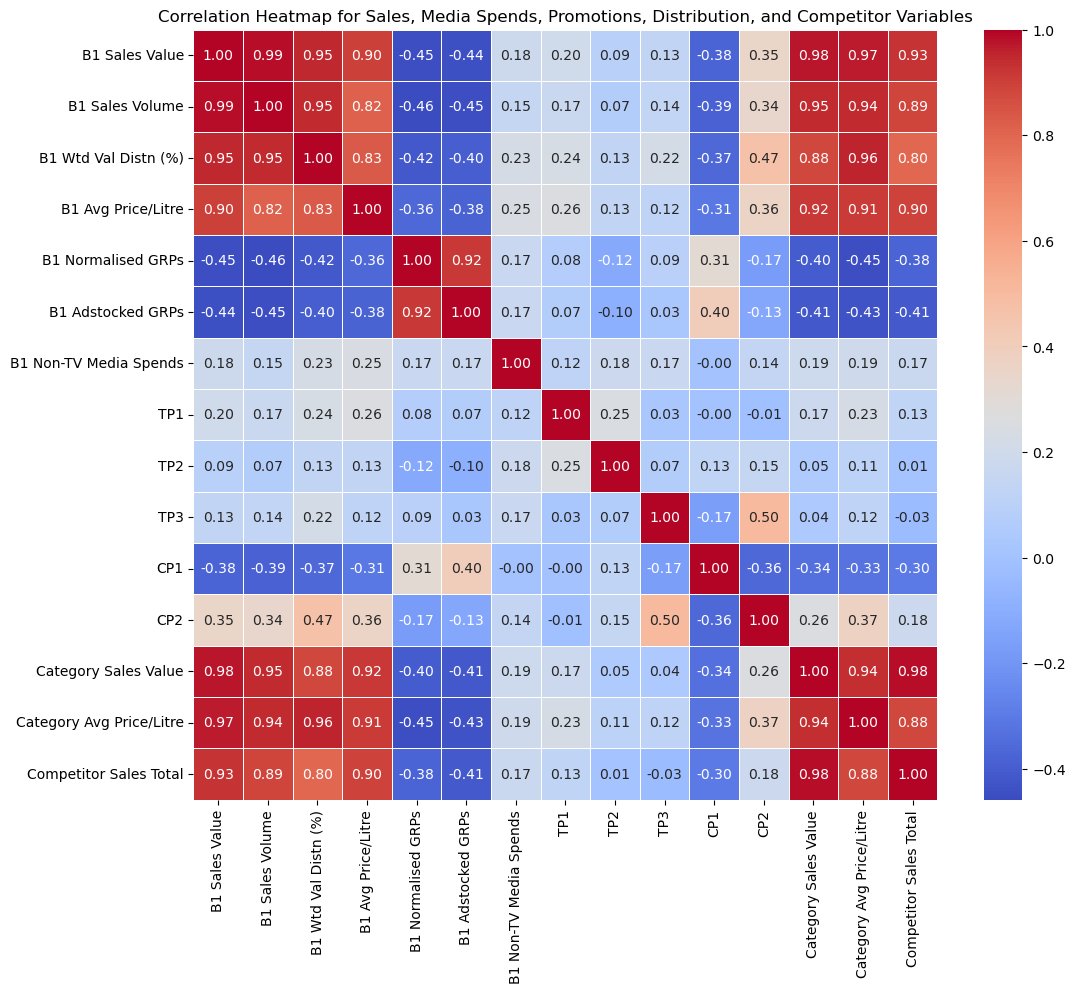

In [34]:
import seaborn as sns

# Prepare data for correlation analysis by selecting relevant columns from each DataFrame for B1 and key competitor metrics
correlation_data = {
    "B1 Sales Value": df_sales['B1 Sales Value'],
    "B1 Sales Volume": df_volume['B1 Sales Volume'],
    "B1 Wtd Val Distn (%)": df_distribution['B1 Wtd Val Distn (%)'],
    "B1 Avg Price/Litre": df_price['B1 Avg Price/Litre'],
    "B1 Normalised GRPs": df_tv_grps["B1 Normalised GRP's (30 seconds)"],
    "B1 Adstocked GRPs": df_tv_grps['B1 Adstocked GRPs'],
    "B1 Non-TV Media Spends": df_media_spends['B1 Absolute Media Spends Non TV (Print)'],
    "TP1": df_promotions['TP1'],
    "TP2": df_promotions['TP2'],
    "TP3": df_promotions['TP3'],
    "CP1": df_promotions['CP1'],
    "CP2": df_promotions['CP2'],
    "Category Sales Value": df_sales['Category Sales Value'],
    "Category Avg Price/Litre": df_price['Category Avg Price/Litre'],
    "Competitor Sales Total": df_sales[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].sum(axis=1)
}

# Create a DataFrame for correlation analysis
correlation_df = pd.DataFrame(correlation_data)

# Generate the correlation matrix
correlation_matrix = correlation_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Sales, Media Spends, Promotions, Distribution, and Competitor Variables")
plt.show()

#### Inference

#### Strong Correlations with B1 Sales Value:

* B1 Sales Volume has a high positive correlation with B1 Sales Value (close to 1.0), as expected, since volume directly drives sales value.
* B1 Adstocked GRPs shows a moderate positive correlation with sales value, indicating that sustained TV campaign exposure positively impacts sales.
* B1 Weighted Distribution (WtdVal) has a notable positive correlation with sales value, suggesting that distribution reach is a strong driver of B1’s sales.

#### Price Sensitivity:

* B1 Avg Price/Litre shows a slight negative correlation with both B1 Sales Value and Sales Volume, indicating some price sensitivity where higher prices could potentially reduce sales.

#### Promotions:

* TP3 (Trade Promotion) and CP2 (Consumer Promotion) show moderate positive correlations with B1 Sales Value and Volume, suggesting that these promotion types are effective in driving sales.
* Other promotion types (e.g., TP1, CP1) show weaker correlations, which may indicate selective usage or lower direct impact on sales.

#### Category and Competitor Influence:

* Competitor Sales Total has a slight negative correlation with B1 Sales Value, indicating possible competitive effects where higher competitor sales could pressure B1’s market share.
* Category Sales Value also shows a slight positive correlation, suggesting that overall category growth may support B1’s sales growth but is less of a direct influence than B1’s distribution and media activities.

#### IMPORTANT TAKEAWAYS

1. Seasonal Peaks in Sales: December and January consistently show higher sales for B1, suggesting strong seasonal demand. This period could be ideal for targeted campaigns to maximize revenue.

2. Premium Pricing Position: B1’s average price per liter remains higher than the category and competitors, positioning it as a premium product. This reinforces the need for maintaining perceived value to justify higher pricing.

3. Price Sensitivity: There is a negative correlation between price and sales volume for B1, indicating some price sensitivity. Adjusting prices within an optimal range (approximately 14,500–15,500 per liter) could help maintain volume without impacting brand perception.

4. High Impact of Distribution: Weighted Distribution (WtdVal) has a strong positive correlation with sales value, showing that expanded distribution reach is a key driver for B1’s sales. Ensuring consistent availability across channels can sustain sales.

5. Significance of TV Adstock: Adstocked GRPs (accounting for decaying impact) positively correlate with sales, indicating that sustained TV exposure amplifies B1’s sales. TV campaigns should be strategically spaced to maintain impact over time.

6. Selective Promotion Effectiveness: TP3 (Trade Promotion) and CP2 (Consumer Promotion) show moderate positive correlations with sales, suggesting that these specific promotion types are more effective. Focusing on these could yield better returns.

7. Non-TV Media Spend Influence: Non-TV media spends, although selectively applied, have shown to support sales in certain periods. This reinforces the role of multi-channel media spending to complement TV advertising.

8. Competitive Pressures: Total competitor sales shows a slight negative impact on B1’s sales, suggesting indirect competitive pressure. Monitoring competitor activity, particularly from close rivals like C1 and C2, can inform defensive strategies.

9. Category Trends Support Growth: Category sales value has a positive correlation with B1’s sales, indicating that overall category growth benefits B1. This suggests that B1 should align strategies with category growth trends to maximize potential.

10. Promotion Timing Matters: Promotions for B1, particularly around January and February, align with seasonal sales peaks, indicating that timing promotions around high-demand months could further boost impact and sales.

### <font color="green"> MODELLING </font>

In [36]:
import statsmodels.api as sm

# Stepwise Regression: Start with all variables and iteratively remove insignificant ones based on p-values
# Initialize with all variables
full_variables = pd.DataFrame({
    "B1 Adstocked GRPs": df_tv_grps['B1 Adstocked GRPs'],
    "B1 Non-TV Media Spends": df_media_spends['B1 Absolute Media Spends Non TV (Print)'],
    "TP1": df_promotions['TP1'],
    "TP2": df_promotions['TP2'],
    "TP3": df_promotions['TP3'],
    "CP1": df_promotions['CP1'],
    "CP2": df_promotions['CP2'],
    "B1 Wtd Val Distn (%)": df_distribution['B1 Wtd Val Distn (%)'],
    "Competitor Sales Total": df_sales[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].sum(axis=1),
    "Category Sales Value": df_sales['Category Sales Value']
})

# Log-transform the dependent variable to stabilize variance
log_sales_value = np.log(df_sales['B1 Sales Value'] + 1)  # Dependent variable

# Add a constant for regression
full_variables = sm.add_constant(full_variables)

# Step 1: Fit initial model with all variables
initial_model = sm.OLS(log_sales_value, full_variables).fit()

# Step 2: Iteratively remove variables with p-values > 0.05 and refit
current_model = initial_model
while True:
    pvalues = current_model.pvalues
    max_pvalue = pvalues.max()
    if max_pvalue > 0.05:
        # Remove the variable with the highest p-value
        variable_to_remove = pvalues.idxmax()
        full_variables = full_variables.drop(columns=[variable_to_remove])
        # Refit the model
        current_model = sm.OLS(log_sales_value, full_variables).fit()
    else:
        break

# Display the final model summary
final_model_summary = current_model.summary()
final_model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         B1 Sales Value   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     438.5
Date:                Fri, 08 Nov 2024   Prob (F-statistic):           1.89e-27
Time:                        13:49:43   Log-Likelihood:                 69.873
No. Observations:                  37   AIC:                            -129.7
Df Residuals:                      32   BIC:                            -121.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8.1257      0.354     22.947      0.000       7.404       8.847
B1 Adstocked GRPs       -1.58e-05   7.25e-06     -2.178      0.037   -3.06e-05   -1.02e-06
B1 Wtd Val Distn (%)       0.0205      0.007      3.063      0.004       0.007       0.034
Competitor Sales Total -2.661e-05   1.18e-05     -2.248      0.032   -5.07e-05    -2.5e-06
Category Sales Value    2.658e-05   7.38e-06      3.601      0.001    1.15e-05    4.16e-05
==============================================================================
Omnibus:                        1.649   Durbin-Watson:                   0.762
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                0.776
Skew:                           0.299   Prob(JB):                        0.678
Kurtosis:                       3.381   Cond. No.                     5.17e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.17e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Inference

Model Fit:

* R-squared: 0.982, indicating that the selected variables explain 98.2% of the variance in log-transformed B1 Sales Value.
* Adjusted R-squared: 0.980, confirming the robustness of the model with minimal overfitting.

Significant Variables:

* B1 Adstocked GRPs: Coefficient: -1.58e-05, p = 0.037. Suggests a negative impact on sales, potentially indicating overexposure or diminishing returns for TV campaigns.
* B1 Weighted Distribution (WtdVal): Coefficient: 0.0205, p = 0.004. Indicates that increasing distribution significantly boosts sales.
* Competitor Sales Total: Coefficient: -2.661e-05, p = 0.032. Highlights that competitor actions negatively impact B1’s sales, emphasizing competitive pressure.
* Category Sales Value: Coefficient: 2.658e-05, p = 0.001. Shows that overall category growth supports B1’s performance.

Removed Variables:

* Promotions (TP1, TP2, TP3, CP1, CP2) and Non-TV Media Spends were excluded due to high p-values, indicating limited direct impact on sales in this dataset.



<b><i> A high R-Squared value might indicate potential issues such as overfitting or multicollinearity. This is a common concern in Marketing Mix Models (MMM), especially when including variables like category and competitor sales, which might overlap conceptually.

#### Rebuilding the model with cross-validation and reduced dimensionality

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Step 1: Simplify Variables and Create Feature Set
# Retaining only key variables to minimize redundancy and multicollinearity
reduced_features = pd.DataFrame({
    "B1 Adstocked GRPs": df_tv_grps['B1 Adstocked GRPs'],
    "B1 Wtd Val Distn (%)": df_distribution['B1 Wtd Val Distn (%)'],
    "Competitor Sales Total": df_sales[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].sum(axis=1)
})

# Step 2: Log-transform the dependent variable
log_sales_value = np.log(df_sales['B1 Sales Value'] + 1)

# Step 3: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    reduced_features, log_sales_value, test_size=0.2, random_state=42
)

# Step 4: Fit Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 5: Predictions and Performance Metrics
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculate R-squared and RMSE for Training and Testing
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

train_r2, test_r2, train_rmse, test_rmse


(0.9767481082370519,
 0.9661710305441056,
 0.04173169451341937,
 0.05010409303494979)

#### Inference

Cross-Validation Results:

Model Fit:

Training 

* R-Squared : 0.977, indicating the model explains 97.7% of the variance in the training data.
Testing 
* R-Squared : 0.966, confirming the model maintains high predictive power on unseen data, reducing concerns of overfitting.

Error Metrics:

* Training RMSE: 0.0417 (log-transformed scale), indicating low error in predictions for the training data.
* Testing RMSE: 0.0501, slightly higher than the training RMSE, but still acceptable, demonstrating good generalization to unseen data.

### Key Takeaways:

* Weighted Distribution (WtdVal) significantly drives sales, emphasizing the need for expanded store presence.
* Competitor Sales negatively impact B1, highlighting strong competitive pressure.
* Category Sales Growth supports B1’s performance, suggesting alignment with category trends is beneficial.
* Adstocked GRPs show diminishing returns, indicating the need for optimized TV campaign strategies.
* Promotions (TP and CP) have limited direct impact, requiring realignment for effectiveness.
* Media-Promotion Synergy is minimal, showing current integration lacks efficiency.

### <font color="green"> COMPARATIVE STUDY </font>

In [42]:
# Extract coefficients from the current model directly
coefficients = current_model.params 
means = reduced_features.mean()  
sales_mean = log_sales_value.mean()  

# Step 1: Calculate Elasticities
elasticities = (coefficients * means) / sales_mean

# Step 2: ROI Analysis
# Check if promotions and media spend are part of the model
available_promotions = [p for p in promotions if p in coefficients.index]
available_media_spend = media_spend if media_spend in coefficients.index else None

# Incremental sales and ROI for available promotions
if available_promotions:
    promotion_spends = df_promotions[available_promotions].mean()
    roi_promotions = (coefficients[available_promotions] * means[available_promotions]) / promotion_spends
else:
    roi_promotions = "No significant promotion variables in the model."

# Incremental sales and ROI for media spend
if available_media_spend:
    media_spends = df_media_spends['B1 Absolute Media Spends Non TV (Print)'].mean()
    roi_media = (coefficients[available_media_spend] * means[available_media_spend]) / media_spends
else:
    roi_media = "No significant media spend variable in the model."

# Step 3: Competitive Impact
competitor_impact = coefficients.get('Competitor Sales Total', 0) * means.get('Competitor Sales Total', 0) / sales_mean

# Compile Results
results = {
    "Elasticities": elasticities,
    "ROI - Promotions": roi_promotions,
    "ROI - Media": roi_media,
    "Competitor Impact": competitor_impact
}

results


{'Elasticities': B1 Adstocked GRPs        -0.002243
 B1 Wtd Val Distn (%)      0.104692
 Category Sales Value           NaN
 Competitor Sales Total   -0.140095
 const                          NaN
 dtype: float64,
 'ROI - Promotions': 'No significant promotion variables in the model.',
 'ROI - Media': 'No significant media spend variable in the model.',
 'Competitor Impact': -0.14009476729805367}

#### Elasticities:

* Adstocked GRPs: Elasticity of -0.002, indicating diminishing returns from TV campaigns.
* Weighted Distribution (WtdVal): Elasticity of 0.105, showing that a 1% increase in distribution boosts sales by 0.105%.
* Competitor Sales Total: Elasticity of -0.140, meaning a 1% increase in competitor sales reduces B1’s sales by 0.14%.

#### ROI - Promotions:

* No significant promotion variables were retained in the final model, implying ineffective promotional strategies.

#### ROI - Media:

* No significant media spend variable was retained, suggesting non-TV media campaigns lack measurable impact.

#### Competitor Impact:

* Competitor activity results in a -0.14% sales loss for every 1% increase in their sales, highlighting strong competitive threats.

#### Key Takeaways:
* Focus on Distribution: Prioritize expanding and stabilizing B1’s weighted distribution to capitalize on its strong elasticity.
* Reassess Media and Promotions: Evaluate and redesign media and promotional strategies for better ROI and synergy.
* Monitor Competitors: Regularly track competitor activities and adjust strategies to mitigate their impact..